In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'pyproject.toml').exists():
            return p
    raise FileNotFoundError('pyproject.toml not found')

repo_root = find_repo_root(Path.cwd().resolve())
sys.path.append(str(repo_root))

from src.data.preprocessing import load_processed_ed_data, ROOT

In [19]:
ed_triage = load_processed_ed_data()
vitalsign = pd.read_csv(ROOT / 'vitalsign.csv')


<class 'pandas.DataFrame'>


/var/folders/sp/1pw98vl56q78pmw9vhk950900000gn/T/ipykernel_99865/1737642008.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


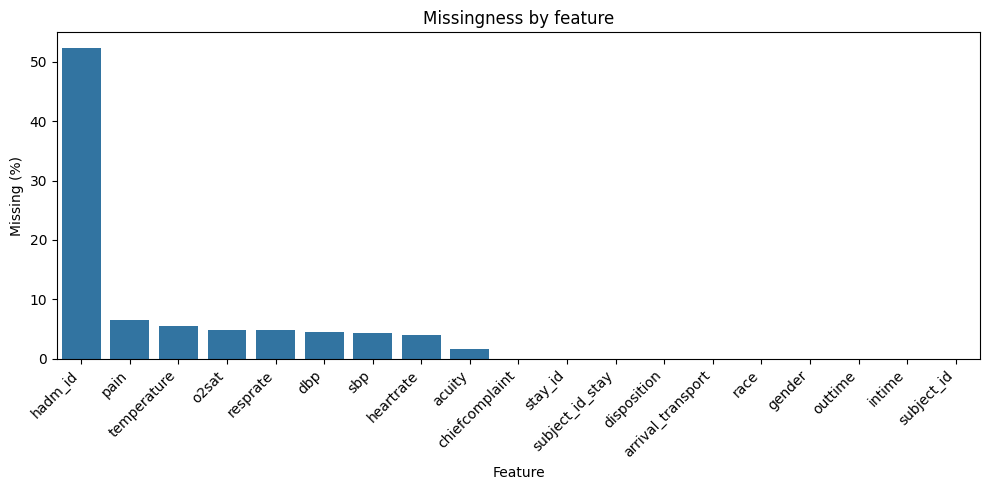

In [20]:
missing_pct = (ed_triage.isna().mean().sort_values(ascending=False) * 100).round(2)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=missing_pct.index, y=missing_pct.values, color="#1f77b4", ax=ax)
ax.set_ylabel("Missing (%)")
ax.set_xlabel("Feature")
ax.set_title("Missingness by feature")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

**NOTE**: hadm_id is often missing because its not required that an individual is admitted to the hospital after their ED stay

In [21]:
vital_cols = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain"]
numeric_summary = ed_triage[vital_cols].describe().T
numeric_summary["missing_pct"] = (ed_triage[vital_cols].isna().mean() * 100).round(2)
display(numeric_summary.round(2))

,count,mean,std,min,25%,50%,75%,max,missing_pct
temperature,397530.0,98.10,0.93,96.0,97.6,98.0,98.6,104.0,5.54
heartrate,403813.0,85.06,17.63,20.0,72.0,84.0,96.0,256.0,4.05
resprate,400610.0,17.54,2.32,6.0,16.0,18.0,18.0,80.0,4.81
o2sat,400372.0,98.40,2.02,70.0,97.0,99.0,100.0,100.0,4.87
sbp,402619.0,134.94,22.21,50.0,120.0,133.0,148.0,250.0,4.33
dbp,401868.0,77.46,14.55,30.0,68.0,77.0,87.0,150.0,4.51
pain,393077.0,4.43,4.08,-1.0,0.0,5.0,8.0,134.0,6.60


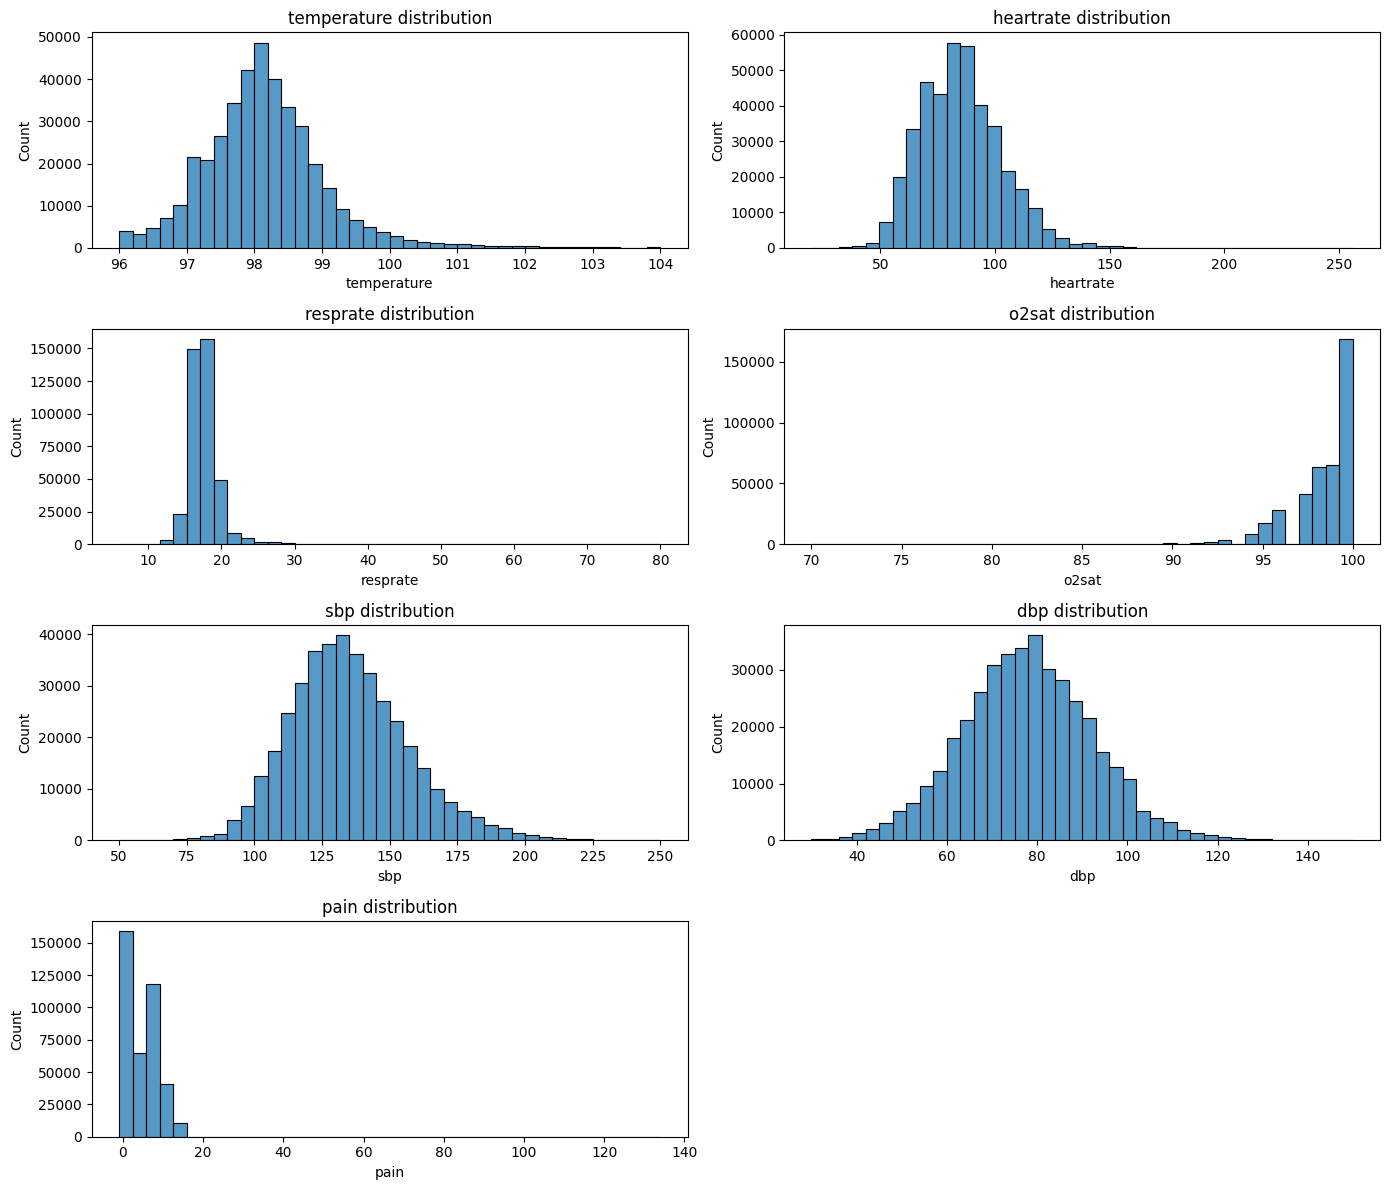

In [22]:
plot_cols = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain"]
rows = int(np.ceil(len(plot_cols) / 2))
fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 3))
axes = axes.flatten()
for idx, col in enumerate(plot_cols):
    ax = axes[idx]
    sns.histplot(ed_triage[col], bins=40, ax=ax, color="#1f77b4")
    ax.set_title(f"{col} distribution")
    ax.set_xlabel(col)
for ax in axes[len(plot_cols):]:
    ax.set_visible(False)
plt.tight_layout()


,acuity,encounters,pct
3,1.0,23559,5.60
1,2.0,137688,32.72
0,3.0,223212,53.04
2,4.0,28326,6.73
5,5.0,1093,0.26
4,NaN,6982,1.66


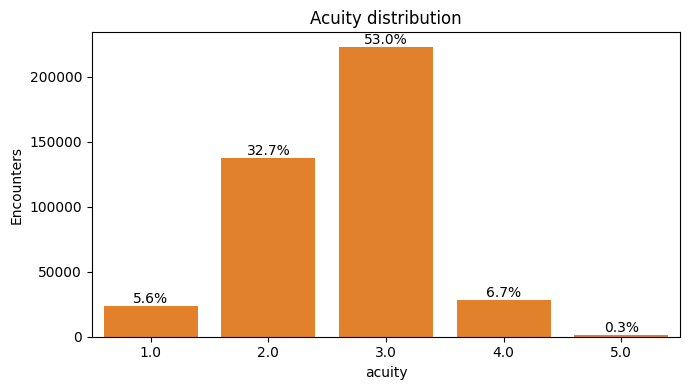

In [23]:
acuity_counts = (
    ed_triage["acuity"]
    .value_counts(dropna=False)
    .rename_axis("acuity")
    .reset_index(name="encounters")
    .sort_values(by="acuity")
)
acuity_counts["pct"] = (acuity_counts["encounters"] / acuity_counts["encounters"].sum() * 100).round(2)
display(acuity_counts)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=acuity_counts, x="acuity", y="encounters", color="#ff7f0e", ax=ax)
ax.set_ylabel("Encounters")
ax.set_title("Acuity distribution")
for patch, pct in zip(ax.patches, acuity_counts["pct"]):
    ax.annotate(f"{pct:.1f}%", (patch.get_x() + patch.get_width() / 2, patch.get_height()), ha="center", va="bottom")
plt.tight_layout()


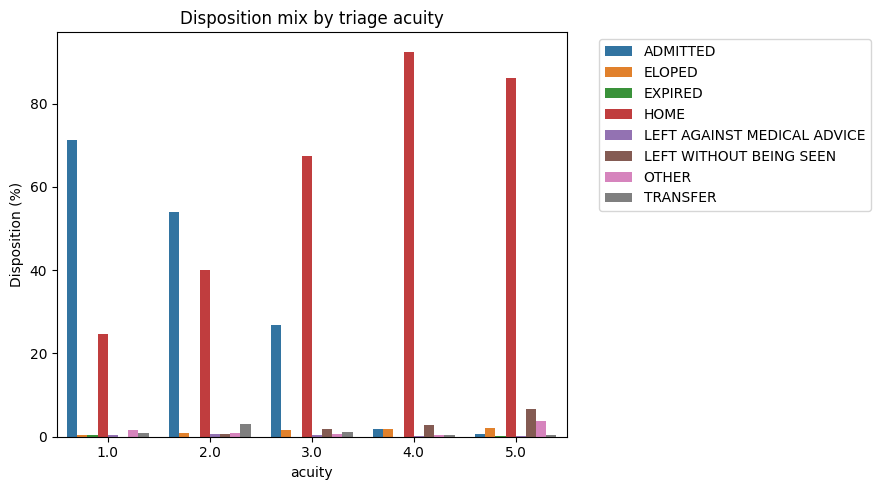

In [24]:
acuity_disposition = (
    ed_triage.groupby(["acuity", "disposition"])
    .size()
    .rename("count")
    .reset_index()
)
acuity_disposition["disposition"] = acuity_disposition["disposition"].fillna("UNKNOWN")
acuity_disposition["share_pct"] = acuity_disposition.groupby("acuity")["count"].transform(lambda col: col / col.sum() * 100)
acuity_order = sorted(ed_triage["acuity"].dropna().unique().tolist())

fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=acuity_disposition, x="acuity", y="share_pct", hue="disposition", order=acuity_order, ax=ax)
ax.set_ylabel("Disposition (%)")
ax.set_title("Disposition mix by triage acuity")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()


,chiefcomplaint,encounters
0,Abd Pain,33480
1,Chest Pain,26798
2,Transfer,23273
3,S/P Fall,21220
4,Dyspnea,18645
5,Headache,13413
6,Fever,12677
7,Etoh,10464
8,Back Pain,9954
9,Dizziness,9361


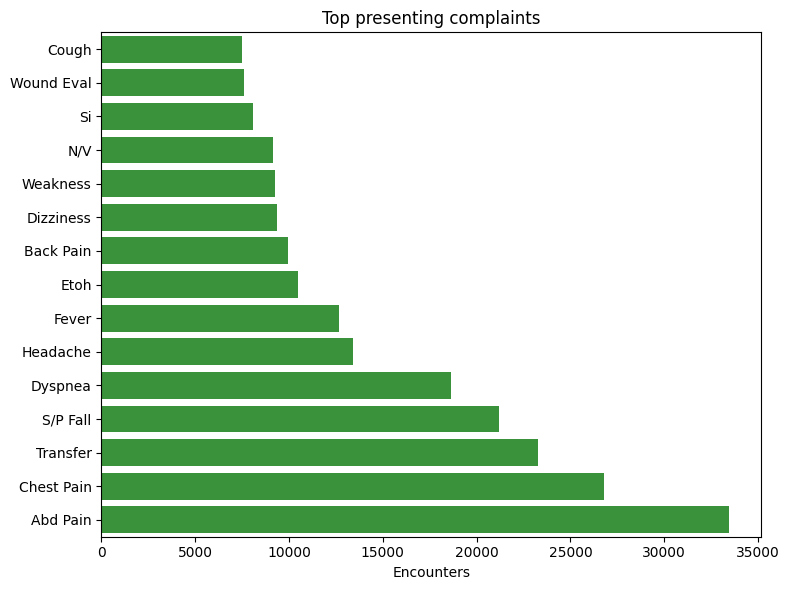

In [25]:
chiefcomplaints = (
    ed_triage["chiefcomplaint"]
    .fillna("UNSPECIFIED")
    .str.split(",")
    .explode()
    .str.strip()
    .replace("", "UNSPECIFIED")
    .str.title()
)
top_chiefcomplaints = chiefcomplaints.value_counts().head(15)
top_chief_df = top_chiefcomplaints.reset_index()
top_chief_df.columns = ["chiefcomplaint", "encounters"]
display(top_chief_df)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=top_chief_df.sort_values("encounters"), y="chiefcomplaint", x="encounters", color="#2ca02c", ax=ax)
ax.set_title("Top presenting complaints")
ax.set_xlabel("Encounters")
ax.set_ylabel("")
plt.tight_layout()


In [26]:
vitals_by_acuity = (
    ed_triage.groupby("acuity")[vital_cols]
    .agg(["median", "mean", "std"])
    .round(1)
)
vitals_by_acuity

temperature            heartrate             resprate             \
            median  mean  std    median  mean   std   median  mean  std   
acuity                                                                    
1.0           98.1  98.3  1.2      92.0  98.2  31.2     18.0  19.3  5.4   
2.0           98.0  98.1  1.0      84.0  85.4  18.2     18.0  17.8  2.5   
3.0           98.0  98.1  0.9      83.0  84.3  15.7     18.0  17.3  1.8   
4.0           98.0  97.9  0.7      81.0  81.9  14.2     16.0  16.9  1.6   
5.0           97.9  97.9  0.7      80.0  80.6  13.9     16.0  16.8  1.9   

        o2sat  ...         sbp                 dbp               pain       \
       median  ...  std median   mean   std median  mean   std median mean   
acuity         ...                                                           
1.0      98.0  ...  4.2  129.0  128.2  30.3   74.0  74.4  18.6    0.0  4.0   
2.0      99.0  ...  2.1  133.0  135.7  23.8   77.0  77.0  15.3    2.0  3.5   
3.0      99.0  ...  1.7  133.0  135.2  20.8   78.0  77.8  13.9    5.0  5.0   
4.0     100.0  ...  1.4  132.0  133.7  18.2   78.0  78.7  12.5    5.0  4.9   
5.0     100.0  ...  1.4  130.0  131.6  17.9   77.0  77.7  12.7    0.0  2.4   

             
        std  
acuity       
1.0     4.9  
2.0     4.2  
3.0     3.9  
4.0     3.7  
5.0     3.5  

[5 rows x 21 columns]

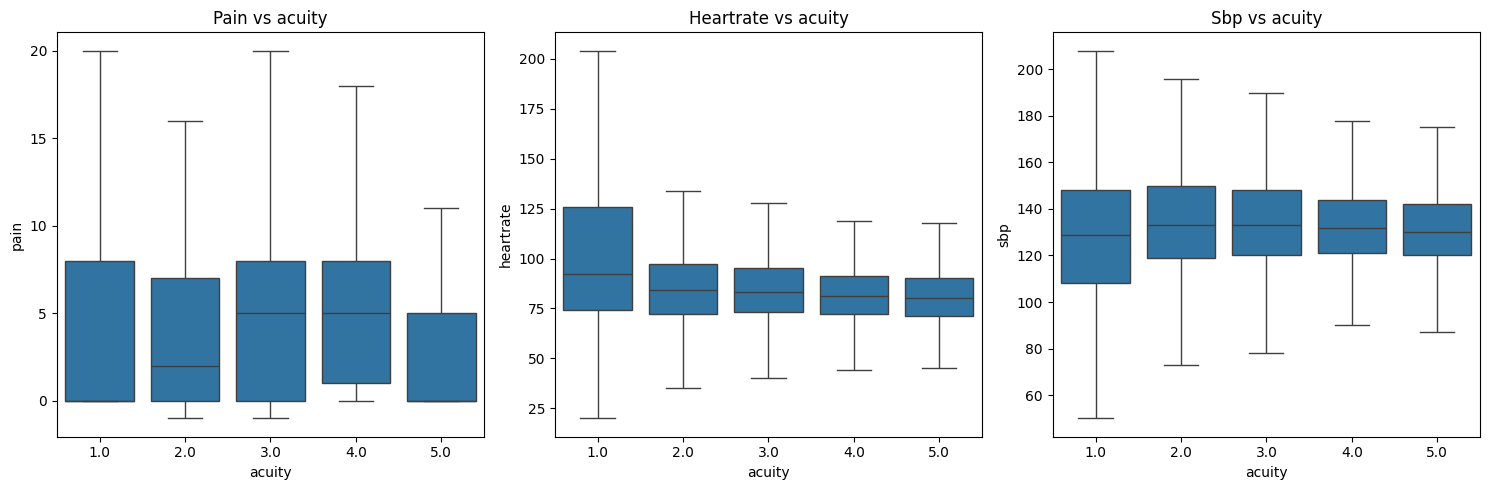

In [27]:
selected_metrics = ["pain", "heartrate", "sbp"]
fig, axes = plt.subplots(1, len(selected_metrics), figsize=(5 * len(selected_metrics), 5))
for metric, ax in zip(selected_metrics, axes if isinstance(axes, (list, np.ndarray)) else [axes]):
    sns.boxplot(
        data=ed_triage,
        x="acuity",
        y=metric,
        order=sorted(ed_triage["acuity"].dropna().unique().tolist()),
        ax=ax,
        showfliers=False,
    )
    ax.set_title(f"{metric.title()} vs acuity")
plt.tight_layout()


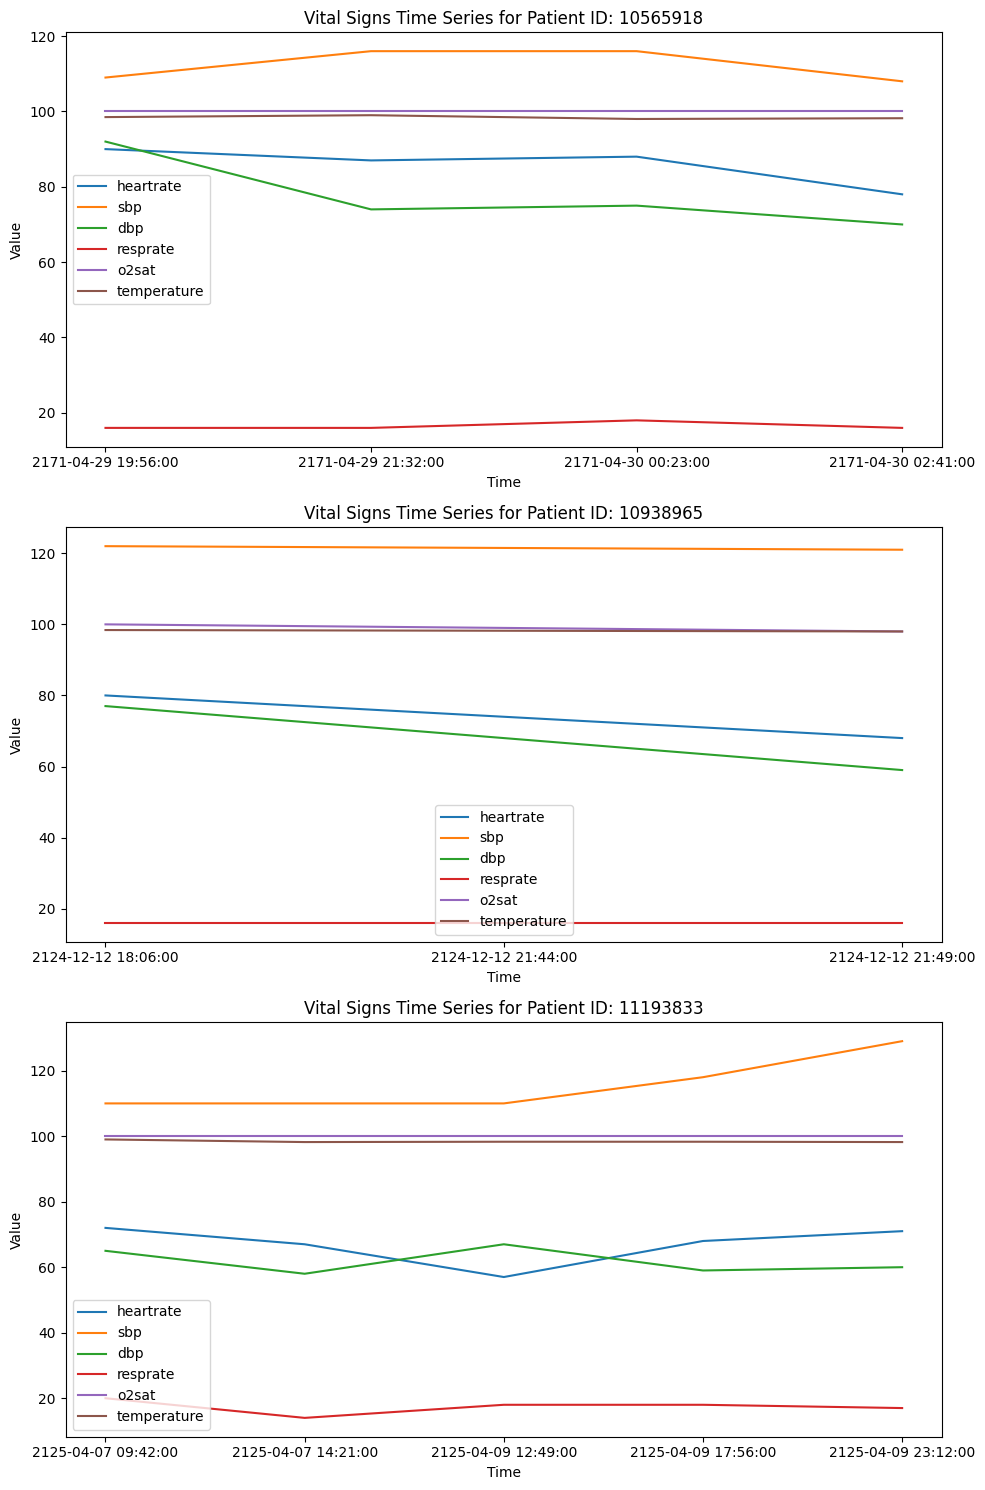

In [28]:
sampled_patients = ed_triage["subject_id"].dropna().unique()
sampled_patients = np.random.choice(sampled_patients, size=3, replace=False)
sampled_data = vitalsign[vitalsign["subject_id"].isin(sampled_patients)]

fig, axes = plt.subplots(len(sampled_patients), 1, figsize=(10, 5 * len(sampled_patients)))
for i, patient_id in enumerate(sampled_patients):
    ax = axes[i] if len(sampled_patients) > 1 else axes
    patient_data = sampled_data[sampled_data["subject_id"] == patient_id].sort_values("charttime")
    for vital in ["heartrate", "sbp", "dbp", "resprate", "o2sat", "temperature"]:
        sns.lineplot(data=patient_data, x="charttime", y=vital, label=vital, ax=ax)
    ax.set_title(f"Vital Signs Time Series for Patient ID: {patient_id}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()
plt.tight_layout()


             temperature  heartrate  resprate     o2sat       sbp       dbp  \
temperature     1.000000   0.814471  0.765718  0.765576  0.794129  0.783818   
heartrate       0.814471   1.000000  0.873035  0.875396  0.919533  0.903845   
resprate        0.765718   0.873035  1.000000  0.812430  0.840624  0.826951   
o2sat           0.765576   0.875396  0.812430  1.000000  0.840621  0.828456   
sbp             0.794129   0.919533  0.840624  0.840621  1.000000  0.979058   
dbp             0.783818   0.903845  0.826951  0.828456  0.979058  1.000000   
pain            0.568139   0.614638  0.575870  0.572832  0.597420  0.588913   
acuity          0.522649   0.615259  0.562488  0.558604  0.594219  0.581779   

                 pain    acuity  
temperature  0.568139  0.522649  
heartrate    0.614638  0.615259  
resprate     0.575870  0.562488  
o2sat        0.572832  0.558604  
sbp          0.597420  0.594219  
dbp          0.588913  0.581779  
pain         1.000000  0.474833  
acuity       0.4

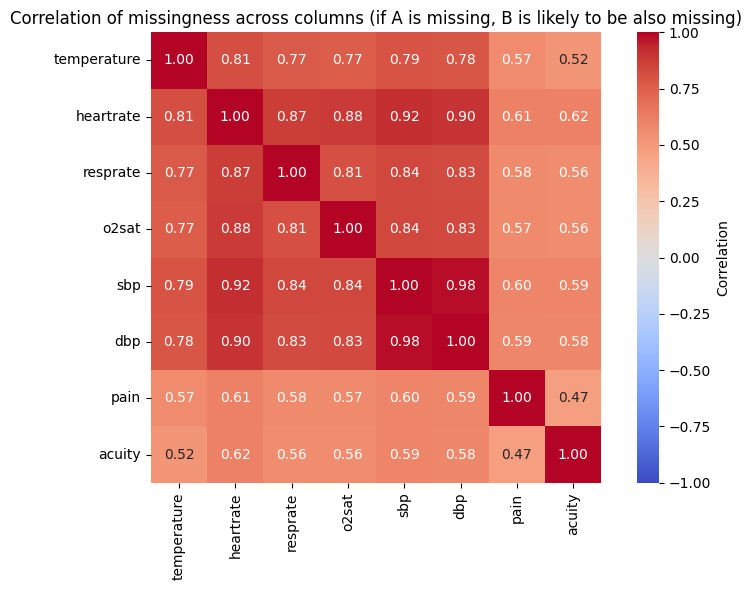

In [29]:
# Correlate missingness across vital sign columns
value_cols = [c for c in ed_triage.select_dtypes(include=[np.number]).columns if c not in {"stay_id", "subject_id", "hadm_id"}]
missing_flags = ed_triage[value_cols].isna().astype(int)
missing_flags = missing_flags.loc[:, missing_flags.sum() > 0]

corr = missing_flags.corr()
print(corr)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"label": "Correlation"},
)
plt.title("Correlation of missingness across columns (if A is missing, B is likely to be also missing)")
plt.tight_layout()
plt.show()

In [30]:
# Association between column values and missingness in other columns
def value_missing_associations(df: pd.DataFrame, id_cols=None) -> pd.DataFrame:
    """Compute association between a column's values and another column's missingness."""
    if id_cols is None:
        id_cols = {"stay_id", "subject_id", "hadm_id"}

    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_cols]
    results = []

    for value_col in numeric_cols:
        x = df[value_col]
        non_null_mask = x.notna()
        x_nonnull = x[non_null_mask]
        if x_nonnull.empty:
            continue

        for missing_col in numeric_cols:
            if missing_col == value_col:
                continue

            y = df.loc[non_null_mask, missing_col].isna().astype(int)
            if y.sum() == 0 or y.sum() == len(y):
                continue  # no missingness signal to model

            r, p = spearmanr(x_nonnull, y)
            results.append({
                "value_col": value_col,
                "missing_col": missing_col,
                "spearman_r": r,
                "p_value": p,
            })

    res_df = pd.DataFrame(results)
    if res_df.empty:
        print("No associations could be computed (no missingness or no numeric columns).")
        return res_df

    res_df = res_df.sort_values("spearman_r", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
    return res_df

assoc_df = value_missing_associations(ed_triage)

             temperature  heartrate  resprate     o2sat       sbp       dbp  \
temperature          NaN  -0.002182  0.004572 -0.001055 -0.001624 -0.000012   
heartrate       0.019846        NaN  0.016627  0.009954  0.014647  0.014795   
resprate        0.025512   0.026284       NaN  0.030731  0.025266  0.028248   
o2sat          -0.021529  -0.017551 -0.024869       NaN -0.004678 -0.004879   
sbp            -0.011794  -0.018105 -0.018258 -0.022486       NaN -0.016369   
dbp            -0.005327  -0.011451 -0.016087 -0.014358  0.002191       NaN   
pain           -0.006989  -0.008212 -0.005954 -0.005463 -0.004708 -0.003475   
acuity         -0.232227  -0.223015 -0.217106 -0.210207 -0.211714 -0.208192   

                 pain    acuity  
temperature -0.002776  0.000974  
heartrate    0.023506  0.002514  
resprate     0.028468 -0.002596  
o2sat       -0.059237 -0.002098  
sbp         -0.020166 -0.002403  
dbp         -0.025774 -0.002142  
pain              NaN  0.000438  
acuity      -0.2

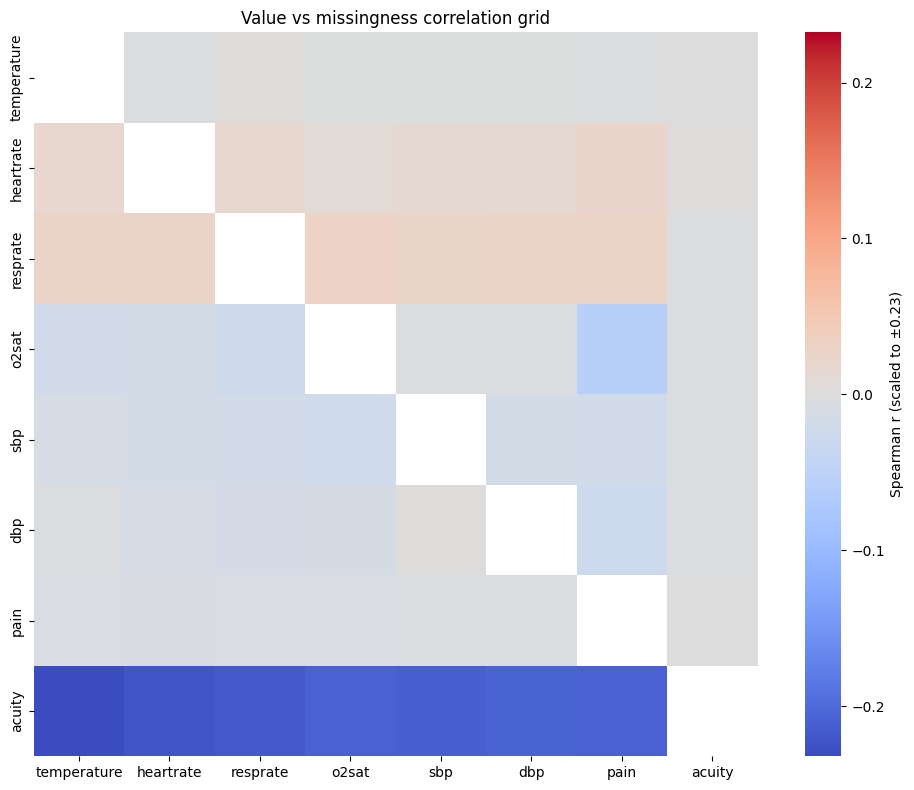

In [31]:
# Grid of correlations: column values vs missingness of other columns
id_cols = {"stay_id", "subject_id", "hadm_id", "subject_id_stay"}
numeric_cols = [c for c in ed_triage.select_dtypes(include=[np.number]).columns if c not in id_cols]

if not numeric_cols:
    print("No numeric columns available for correlation grid.")
else:
    corr_grid = pd.DataFrame(np.nan, index=numeric_cols, columns=numeric_cols)

    for vcol in numeric_cols:
        x = ed_triage[vcol]
        nonnull = x.notna()
        if nonnull.sum() < 3:
            continue
        x_nonnull = x[nonnull]

        for mcol in numeric_cols:
            y = ed_triage.loc[nonnull, mcol].isna().astype(int)
            if y.sum() == 0 or y.sum() == len(y):
                continue  # no missingness variation to correlate

            if spearmanr is not None:
                r, _ = spearmanr(x_nonnull, y)
            else:
                r = x_nonnull.rank().corr(y, method="pearson")

            corr_grid.loc[vcol, mcol] = r

    max_abs = corr_grid.abs().max().max()
    print(corr_grid)
    if pd.isna(max_abs) or max_abs == 0:
        print("No non-null correlations to display.")
    else:
        scale = max(max_abs, 0.05)  # avoid an all-white map when correlations are tiny
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            corr_grid,
            cmap="coolwarm",
            center=0,
            vmin=-scale,
            vmax=scale,
            square=True,
            cbar_kws={"label": f"Spearman r (scaled to ±{scale:.2f})"},
            mask=corr_grid.isna(),
            annot=False,
        )
        plt.title("Value vs missingness correlation grid")
        plt.tight_layout()
        plt.show()

        corr_long = (
            corr_grid.stack()
            .reset_index()
            .rename(columns={"level_0": "value_col", "level_1": "missing_col", 0: "spearman_r"})
        )
        corr_long["abs_r"] = corr_long["spearman_r"].abs()

**Interpretation**: Lower acuity (higher severity) sometimes leads to missingness of other columns. Other feature-to-feature relationships are much less pronounced.

**Rule of thumb for correlation**: |r| = 0.1 small, 0.3 moderate, 0.5+ strong

The spearman r values can be read off on based on the scale on the right

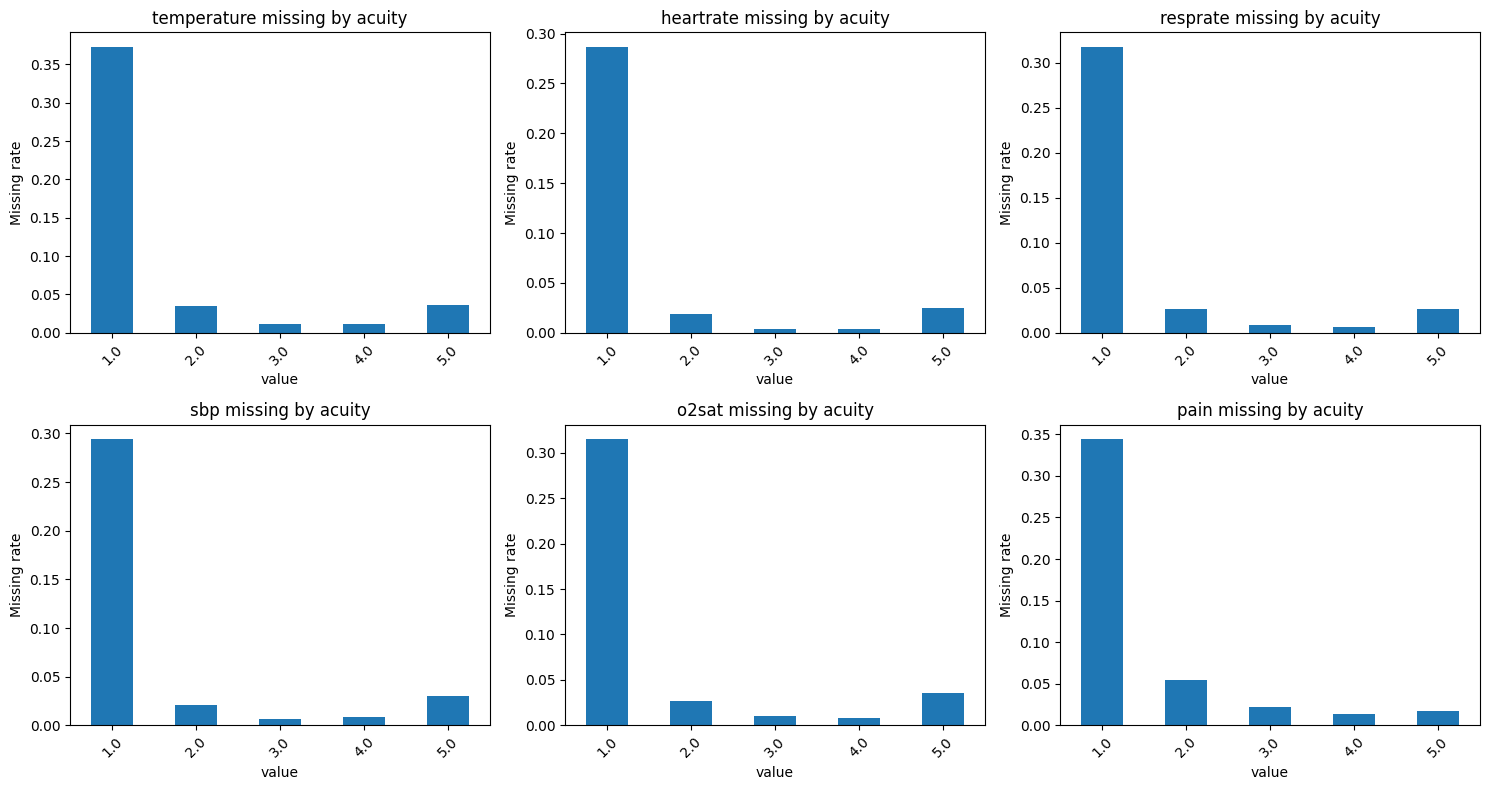

In [32]:
# Additional plots for value/missingness associations
if assoc_df.empty:
    print("No associations to plot.")
else:
    top_n = 6
    top_pairs = assoc_df.head(top_n).copy()
    top_pairs["pair"] = top_pairs.apply(
        lambda r: f"{r['value_col']} -> miss({r['missing_col']})", axis=1
    )

    # Bar chart of strongest associations (signed correlation)
    colors = ["#d62728" if r > 0 else "#1f77b4" for r in top_pairs["spearman_r"]]

    # Small multiples: missingness rate across value categories for top pairs
    ncols = 3
    nrows = int(np.ceil(len(top_pairs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows), squeeze=False)

    for ax, (_, row) in zip(axes.flat, top_pairs.iterrows()):
        vcol, mcol = row["value_col"], row["missing_col"]
        mask = ed_triage[vcol].notna()
        if mask.sum() < 5:
            ax.set_visible(False)
            continue

        # Use exact values instead of binning
        series = ed_triage.loc[mask, vcol]
        bin_rates = (
            ed_triage.loc[mask]
            .assign(value=series)
            .groupby("value")[mcol]
            .apply(lambda s: s.isna().mean())
            .dropna()
        )

        if bin_rates.empty:
            ax.set_visible(False)
            continue

        bin_rates.plot(kind="bar", ax=ax, rot=45, color="#1f77b4")
        ax.set_ylabel("Missing rate")
        ax.set_title(f"{mcol} missing by {vcol}")

    # Hide unused subplots
    for ax in axes.flat:
        if not ax.has_data():
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()
